In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from conformal_prediction import CP
from preprocess_data import recode_variables, split_train_cal_test

In [57]:
f_path = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/data.csv'
df = pd.read_csv(f_path, na_values="None")
df = df.replace(to_replace=' ', value=np.nan)
df = recode_variables(df)

In [58]:
df.dropna(inplace=True)

df = df.sample(n = 500)
ed_dummies = ['Ed_less_9th', 'Ed_9th_11th', 'Ed_HS_GED', 'Ed_some_coll_AA', 'Ed_coll_above', 'Ed_refused', 'Ed_dk']
eth_dummies = ['Eth_Mex_Am', 'Eth_Oth_Hisp', 'Eth_Nonhisp_White', 'Eth_Nonhisp_Black', 'Eth_Other']

X = df[[ 'Age', 'Female',  'Weight', 'Height', 'BMI'] + ed_dummies + eth_dummies]

outcome = 'Waist'
y = df[[outcome]]
y = y[outcome].astype(float)

In [60]:
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression

alpha = 0.05
n_resamplings = 100

no_cal_cov = []
cp_cov = []
for i in range(n_resamplings):
    X_train, X_cal, X_test, y_train, y_cal, y_test = split_train_cal_test(X, y, trn_prop=0.5, cal_prop=0.25)

    reg = CP(X_train, X_cal, y_train, y_cal, verbose=0)
    reg.train(alpha=alpha)
    scores = reg.calculate_scores()
    qhat = reg.calc_qhat(alpha=alpha)
    
    test_pred_df = reg.predict_quantiles(X_test, y_test = y_test)
    
    test_no_cal_df = reg.conformalize_CIs(test_pred_df, qhat=0)
    test_cp_df = reg.conformalize_CIs(test_pred_df)
    
    cov_no_cal = reg.calc_coverage(test_no_cal_df)
    cov = reg.calc_coverage(test_cp_df)
    
    no_cal_cov.append(cov_no_cal)
    cp_cov.append(cov)
    
    print(f"{i}: no-cp: {cov_no_cal}, cp: {cov}")

0: no-cp: 0.84, cp: 0.936
1: no-cp: 0.864, cp: 0.904
2: no-cp: 0.872, cp: 0.904
3: no-cp: 0.936, cp: 0.968
4: no-cp: 0.952, cp: 0.976
5: no-cp: 0.92, cp: 0.92
6: no-cp: 0.84, cp: 0.928
7: no-cp: 0.912, cp: 0.952
8: no-cp: 0.888, cp: 0.952
9: no-cp: 0.872, cp: 0.976
10: no-cp: 0.896, cp: 0.944
11: no-cp: 0.928, cp: 0.952
12: no-cp: 0.952, cp: 0.984
13: no-cp: 0.912, cp: 0.936
14: no-cp: 0.912, cp: 0.952
15: no-cp: 0.96, cp: 0.984
16: no-cp: 0.904, cp: 0.984
17: no-cp: 0.944, cp: 0.992
18: no-cp: 0.904, cp: 0.992
19: no-cp: 0.936, cp: 0.952
20: no-cp: 0.904, cp: 1.0
21: no-cp: 0.912, cp: 0.968
22: no-cp: 0.88, cp: 0.92
23: no-cp: 0.904, cp: 0.952
24: no-cp: 0.8, cp: 0.936
25: no-cp: 0.888, cp: 0.944
26: no-cp: 0.944, cp: 0.992
27: no-cp: 0.896, cp: 0.952
28: no-cp: 0.928, cp: 0.976
29: no-cp: 0.944, cp: 0.968
30: no-cp: 0.864, cp: 0.944
31: no-cp: 0.848, cp: 0.976
32: no-cp: 0.92, cp: 0.952
33: no-cp: 0.88, cp: 0.944
34: no-cp: 0.896, cp: 0.976
35: no-cp: 0.904, cp: 0.936
36: no-cp: 0.91

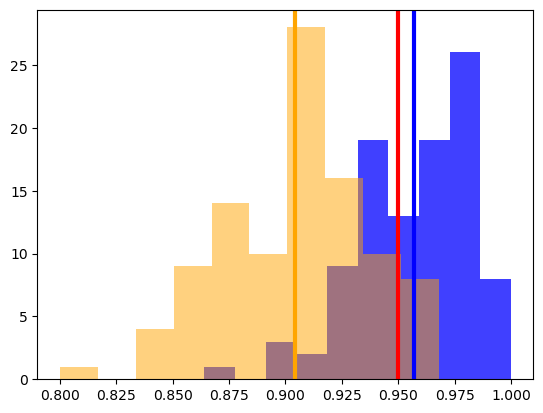

In [71]:
import matplotlib.pyplot as plt
plt.hist(cp_cov, bins=10, color='blue', alpha=0.75)
plt.axvline(x=np.mean(cp_cov), color='b', linewidth=3)
plt.hist(no_cal_cov, bins=10, alpha=0.5, color='orange')
plt.axvline(x=np.mean(no_cal_cov), color='orange', linewidth=3)
plt.axvline(x=1-alpha, color='r', linewidth=3)
plt.show()

In [62]:
np.mean(test_cp_df['diff'])

22.140018088312537